<a href="https://colab.research.google.com/github/PRIEEE/August2022/blob/master/London_Housing_Price_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.6 MB/s 


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [52]:
data = pd.read_csv('/content/gdrive/My Drive/Student Notebooks/archive/housing_in_london_monthly_variables.csv')

In [53]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop redundant columns
    df = df.drop('code', axis=1)
    
    # Drop columns with too many missing values
    df = df.drop('no_of_crimes', axis=1)
    
    # Drop rows with missing target values
    missing_target_rows = df[df['houses_sold'].isna()].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)
    
    # Extract date features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df = df.drop('date', axis=1)

     # One-hot encode the area column
    area_dummies = pd.get_dummies(df['area'], prefix='area')
    df = pd.concat([df, area_dummies], axis=1)
    df = df.drop('area', axis=1)
    
    # Split df into X and y
    y = df['houses_sold']
    X = df.drop('houses_sold', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [54]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [55]:
X_train

,average_price,borough_flag,year,month,area_barking and dagenham,area_barnet,area_bexley,area_brent,area_bromley,area_camden,...,area_south east,area_south west,area_southwark,area_sutton,area_tower hamlets,area_waltham forest,area_wandsworth,area_west midlands,area_westminster,area_yorks and the humber
10752,-0.707342,-1.657173,1.542734,1.315615,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
10236,-0.663007,-1.657173,-0.963307,1.024950,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
4512,-1.004551,0.603437,-1.380980,-1.300369,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
9208,0.430416,0.603437,0.985836,1.024950,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,6.754536,-0.152846,-0.152117,-0.152482,-0.151385
2672,1.130422,0.603437,1.542734,-0.428374,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,-1.051000,0.603437,-1.659429,0.734285,-0.145406,-0.150649,6.720615,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
5192,-0.306718,0.603437,-0.545633,1.606280,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
12172,-0.347968,-1.657173,0.707387,0.443620,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385
235,2.670032,0.603437,0.985836,0.443620,-0.145406,-0.150649,-0.148796,-0.155015,-0.152482,-0.148049,...,-0.148796,-0.156801,-0.152482,-0.148423,-0.146165,-0.148049,-0.152846,-0.152117,-0.152482,-0.151385


In [11]:
y_train

10752     3824.0
10236     6593.0
4512       280.0
9208       334.0
2672       220.0
          ...   
905        281.0
5192       478.0
12172     7823.0
235         27.0
13349    37892.0
Name: houses_sold, Length: 9418, dtype: float64

In [16]:
models = {
    " Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    " K-Nearest Neighbors": KNeighborsRegressor(),
    " Neural Network": MLPRegressor(),
    " Decision Tree": DecisionTreeRegressor(),
    " Random Forest": RandomForestRegressor(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L2 Regularization) trained.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e+08, tolerance: 1.385e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


                        Neural Network trained.
                         Decision Tree trained.
                         Random Forest trained.


In [17]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(name + " RMSE: {:.4f}".format(rmse))

                     Linear Regression RMSE: 3336.2553
 Linear Regression (L2 Regularization) RMSE: 3336.2725
 Linear Regression (L1 Regularization) RMSE: 3336.4065
                   K-Nearest Neighbors RMSE: 2264.7955
                        Neural Network RMSE: 3353.6988
                         Decision Tree RMSE: 2041.7930
                         Random Forest RMSE: 1497.3917


In [18]:
for name, model in models.items():
    print(name + " R^2: {:.4f}".format(model.score(X_test, y_test)))

                     Linear Regression R^2: 0.9237
 Linear Regression (L2 Regularization) R^2: 0.9237
 Linear Regression (L1 Regularization) R^2: 0.9237
                   K-Nearest Neighbors R^2: 0.9649
                        Neural Network R^2: 0.9229
                         Decision Tree R^2: 0.9714
                         Random Forest R^2: 0.9846


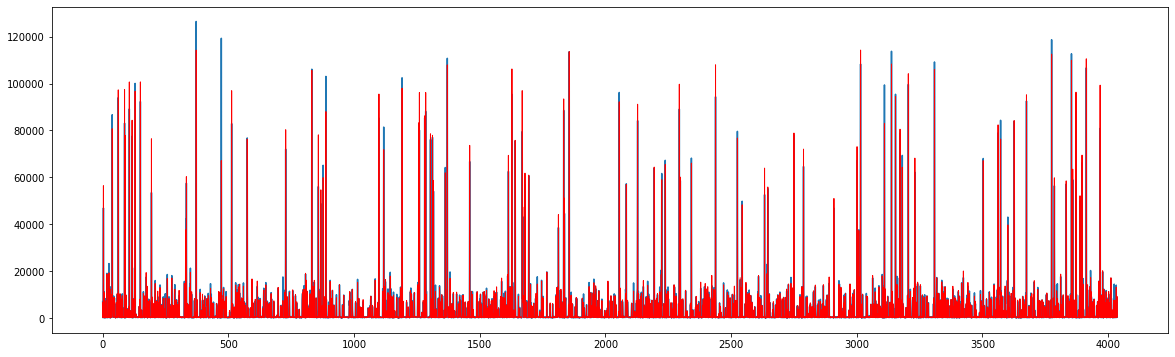

In [35]:

import matplotlib.pyplot as plt
plt.rc('figure', figsize = (20, 6))

model = RandomForestRegressor()
model.fit(X_train,y_train)
x = np.arange(0,4037,1)
y_pred = model.predict(X_test)
plt.plot(x,y_test,label="Test")
plt.plot(x,y_pred,c='r',lw=1,ms=2,label="Prediction")
plt.show()

In [37]:
from sklearn.preprocessing import StandardScaler
slr = StandardScaler()
slr.fit(X_train)
x_train_scaled = slr.transform(X_train)
x_test_scaled = slr.transform(X_test)

In [38]:
import statsmodels.api as sm
xOLS = sm.add_constant(x_train_scaled)  #加上常数项才能回归
reg_OLS = sm.OLS(y_train, xOLS).fit()
reg_OLS.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            houses_sold   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     2291.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        06:24:04   Log-Likelihood:                -90034.
No. Observations:                9418   AIC:                         1.802e+05
Df Residuals:                    9370   BIC:                         1.805e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3895.6536     35.452    109.886      0.000    3826.160    3965.147
x1           777.1899     88.526      8.779      0.000     603.659     950.721
x2         -3044.1179     21.710   -140.219      0.000   -3086.674   -3001.562
x3          -939.0039     68.515    -13.705      0.000   -1073.309    -804.699
x4           322.2527     35.566      9.061      0.000     252.537     391.969
x5          -205.9370     35.547     -5.793      0.000    -275.617    -136.257
x6          -260.6611     34.603     -7.533      0.000    -328.490    -192.833
x7          -212.1967     35.116     -6.043      0.000    -281.031    -143.362
x8          -272.3328     34.516     -7.890      0.000    -339.991    -204.675
x9          -221.5812     34.597     -6.405      0.000    -289.398    -153.764
x10         -387.3645     36.763    -10.537      0.000    -459.428    -315.301
x11         -389.6347     35.817    -10.879      0.000    -459.844    -319.426
x12         -193.4486     34.930     -5.538      0.000    -261.918    -124.979
x13         -256.6681     34.549     -7.429      0.000    -324.392    -188.944
x14         -230.2943     34.473     -6.680      0.000    -297.868    -162.720
x15          125.1508     34.023      3.678      0.000      58.458     191.843
x16         -220.6289     34.786     -6.342      0.000    -288.817    -152.441
x17         1.014e+04     34.144    296.924      0.000    1.01e+04    1.02e+04
x18         -233.8862     34.826     -6.716      0.000    -302.154    -165.619
x19         -284.4219     34.559     -8.230      0.000    -352.165    -216.679
x20         -377.2623     36.417    -10.360      0.000    -448.647    -305.877
x21         -276.2429     34.595     -7.985      0.000    -344.057    -208.429
x22         -259.7290     34.604     -7.506      0.000    -327.560    -191.898
x23         -221.1823     34.947     -6.329      0.000    -289.686    -152.679
x24         -236.4377     34.703     -6.813      0.000    -304.463    -168.412
x25         -251.3376     34.667     -7.250      0.000    -319.293    -183.382
x26         -720.0497     34.531    -20.852      0.000    -787.738    -652.361
x27         -340.2263     34.998     -9.721      0.000    -408.831    -271.622
x28         -560.7602     47.525    -11.799      0.000    -653.920    -467.601
x29         -271.5101     34.580     -7.852      0.000    -339.294    -203.726
x30         -260.2904     34.552     -7.533      0.000    -328.019    -192.562
x31         -224.3122     34.830     -6.440      0.000    -292.586    -156.038
x32          214.2779     33.957      6.310      0.000     147.714     280.841
x33         -262.8590     34.600     -7.597      0.000    -330.683    -195.035
x34         -217.9564     35.051     -6.218      0.000    -286.664    -149.249
x35         -698.0558     34.942    -19.977      0.000    -766.551    -629.561
x3

In [40]:
from sklearn.metrics import r2_score
r2_score(y_test, reg_OLS.predict(sm.add_constant(x_test_scaled)))

0.9237265915768327

[]

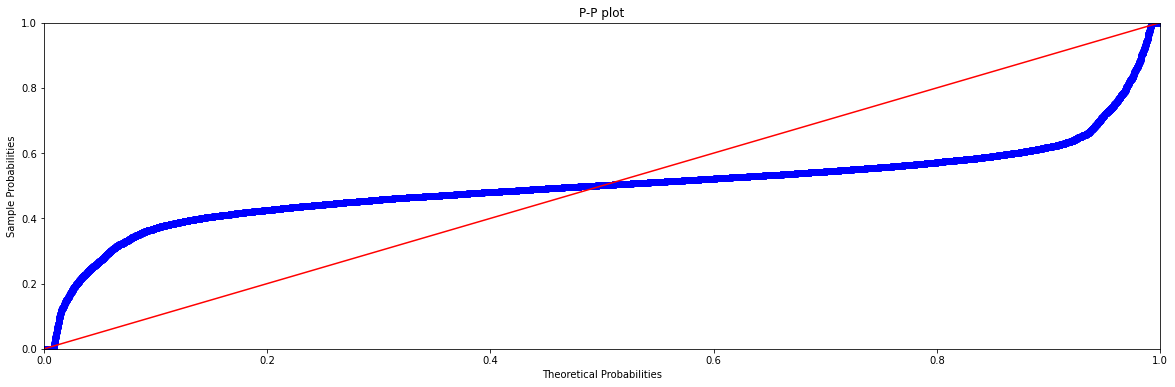

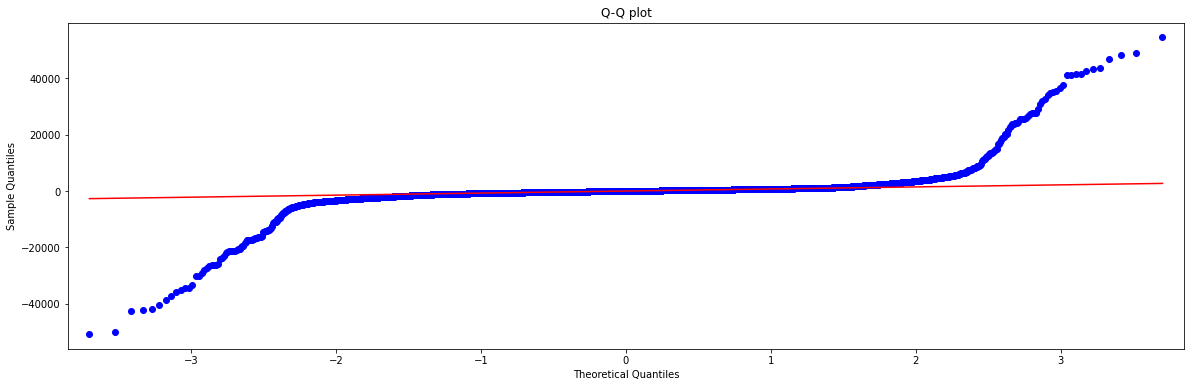

In [42]:
'''残差的正态性检验（PP图和QQ图）'''
pp_qq_plot = sm.ProbPlot(reg_OLS.resid)

pp_qq_plot.ppplot(line = '45')
plt.title('P-P plot')

pp_qq_plot.qqplot(line = 'q')

plt.title('Q-Q plot')# 显示图形plt.show()
plt.plot()